In [1]:
import math
import sys
import os

from functools import reduce

from collections import OrderedDict

import re

import numpy as np
from matplotlib import pyplot as plt


ROOT = "/home/primmere/ide/"
sys.path.append(ROOT)
sys.path.append(os.path.join(ROOT, 'external', 'wdpruning'))
sys.path.append(os.path.join(ROOT, 'external', 'pruning_by_explaining'))

from my_scripts.utils import visualize

from external.wdpruning.vit_wdpruning import VisionTransformerWithWDPruning
from external.pruning_by_explaining.pxp import GlobalPruningOperations, ComponentAttibution, get_vit_composite, \
    ModelLayerUtils
from external.pruning_by_explaining.my_experiments.utils import visualise, plot_layer_head_heatmap, plot_layer_head_pruned, plot_r_accuracy_lines
from external.pruning_by_explaining.models import ModelLoader
from external.pruning_by_explaining.my_datasets import WaterBirds, WaterBirdDataset

from my_utils import evaluate, evaluate_gradients, prune_l2
from ISIC_ViT.isic_data import ISICDataset
from external.dfr.wb_data import WaterBirdsDataset

import argparse

import torchvision
import torch
from torchvision.models import vit_b_16
import torch.nn as nn
from typing import Dict, List, Tuple


In [2]:
device = torch.device("cuda")
dataset = "wb"
layer_type = "linear"
#data_dir = 
#checkpoint = torch.load("/home/primmere/logs/isic_logs_4/vit_isic_v2.pt", map_location=device, weights_only=True)


In [3]:
if dataset == "wb":
    data_dir = "/scratch_shared/primmere/waterbird"

    checkpoint = torch.load("/home/primmere/ide/dfr/logs/vit_waterbirds.pth", map_location=device, weights_only=True)

    transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(256),
                    torchvision.transforms.CenterCrop(224),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
    
    test_dataset = WaterBirdsDataset(basedir=data_dir,
                                         transform=transform,
                                         split="test")
    val_dataset = WaterBirdsDataset(basedir=data_dir,
                                        transform=transform,
                                        split="val")
    train_dataset = WaterBirdsDataset(basedir=data_dir,
                                          transform=transform,
                                          split="train")

    loader_kwargs = {'batch_size': 32, 'num_workers': 8, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, **loader_kwargs)
    val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, **loader_kwargs)
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=False, **loader_kwargs)

if dataset == "isic":
    label_csv = '/scratch_shared/primmere/isic/metadata_w_split_v2_w_elmos_modifications.csv'
    data_dir = "/scratch_shared/primmere/isic/isic_224/raw_224_with_selected"
    checkpoint = torch.load("/home/primmere/logs/isic_logs_4/vit_isic_v2.pt", map_location=device, weights_only=True)
    
    
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    trainset = ISICDataset(basedir=data_dir,
                           csv_file=label_csv,
                           transform=train_transform,
                           split="train")
    testset = ISICDataset(basedir=data_dir,
                          csv_file=label_csv,
                          transform=test_transform,
                          split="test")
    valset = ISICDataset(basedir=data_dir,
                         csv_file=label_csv,
                         transform=test_transform,
                         split="val")
    
    
    loader_kwargs = {'batch_size': 32, 'num_workers': 8, 'pin_memory': True}
    train_loader = torch.utils.data.DataLoader(trainset, shuffle=True, **loader_kwargs)
    test_loader = torch.utils.data.DataLoader(testset, shuffle=False, **loader_kwargs)
    val_loader = torch.utils.data.DataLoader(valset, shuffle=False, **loader_kwargs)
    











tensor([2255., 2255.,  642.,  642.])
tensor([456., 456., 143., 144.])
tensor([3518.,  185.,   55., 1037.])


In [4]:
model = vit_b_16(num_classes = 2)
model.to(device)


model.load_state_dict(checkpoint)


<All keys matched successfully>

In [5]:
pruner = prune_l2.L2VitB16Pruner(layer_type)
metric = evaluate.AccuracyWithGroups()

In [6]:
accs = []
group_accs = []
rates = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9,0.92,0.94,0.96,0.98]
pruned = pruner.prune(model, 0.0000001)

d = OrderedDict()
for i in range(len(pruned['scores'])):
    d[i] = pruned['scores'][i].detach().cpu().numpy()
#plot_layer_head_heatmap(d, save_path = f'l2 viz/{dataset}_{layer_type}/attn_head_heatmap.png')

print(d)

OrderedDict([(0, array([0.3167594 , 0.27217323, 0.94156003, ..., 0.25973606, 1.2726034 ,
       0.31096992], dtype=float32)), (1, array([2.376014  , 1.6860558 , 0.6090278 , ..., 2.5355709 , 1.0283816 ,
       0.53596765], dtype=float32)), (2, array([2.029362 , 1.9729983, 0.5347929, ..., 1.9935828, 1.9810853,
       0.7693142], dtype=float32)), (3, array([0.76286685, 0.776666  , 0.93937194, ..., 0.86073524, 0.85444623,
       0.6585011 ], dtype=float32)), (4, array([0.7251074 , 1.1601133 , 0.8214308 , ..., 0.83159286, 0.83648926,
       0.974167  ], dtype=float32)), (5, array([1.0625159 , 0.7551558 , 0.95405656, ..., 0.84389824, 0.70284414,
       1.2611828 ], dtype=float32)), (6, array([1.2288156 , 1.255917  , 1.3739152 , ..., 0.94697464, 1.1259305 ,
       1.0901948 ], dtype=float32)), (7, array([1.1662457, 1.4972925, 1.4817868, ..., 1.2056365, 1.3530291,
       1.364699 ], dtype=float32)), (8, array([1.3748306, 1.8302058, 1.1640683, ..., 1.1675687, 1.3193408,
       1.2722863], dtype

In [7]:
for r in rates:
        pruned = pruner.prune(model, r)
        print(r)
        test_results = evaluate.evaluate(model, test_loader, metric, device)
        accs.append(test_results['total_accuracy'])
        group_accs.append(test_results['groups_accuracy'])

0.1


Evaluating: 100%|██████████| 182/182 [00:32<00:00,  5.68batch/s]


0.2


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.77batch/s]


0.3


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.4


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.5


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.77batch/s]


0.6


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.7


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.79batch/s]


0.8


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.9


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.79batch/s]


0.92


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.94


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.96


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.78batch/s]


0.98


Evaluating: 100%|██████████| 182/182 [00:31<00:00,  5.79batch/s]


In [8]:
for i in range(len(rates)):
    print(f'{rates[i]} & {accs[i]:.3f} & {group_accs[i][0]:.3f} & {group_accs[i][1]:.3f} & {group_accs[i][2]:.3f} & {group_accs[i][3]:.3f} \\\\')


0.1 & 0.884 & 0.994 & 0.817 & 0.684 & 0.931 \\
0.2 & 0.646 & 0.832 & 0.588 & 0.296 & 0.547 \\
0.3 & 0.404 & 0.472 & 0.120 & 0.636 & 0.930 \\
0.4 & 0.462 & 0.578 & 0.210 & 0.567 & 0.840 \\
0.5 & 0.418 & 0.490 & 0.146 & 0.628 & 0.910 \\
0.6 & 0.503 & 0.678 & 0.261 & 0.449 & 0.798 \\
0.7 & 0.695 & 0.944 & 0.714 & 0.086 & 0.363 \\
0.8 & 0.664 & 0.939 & 0.609 & 0.095 & 0.466 \\
0.9 & 0.444 & 0.558 & 0.161 & 0.590 & 0.889 \\
0.92 & 0.400 & 0.442 & 0.141 & 0.671 & 0.896 \\
0.94 & 0.406 & 0.456 & 0.140 & 0.668 & 0.900 \\
0.96 & 0.428 & 0.530 & 0.138 & 0.612 & 0.900 \\
0.98 & 0.546 & 0.780 & 0.306 & 0.341 & 0.769 \\


In [9]:
array = np.zeros((len(rates),6))
array[:,0] = rates
array[:,1] = accs
for i in range(len(rates)):
    array[i,2] = group_accs[i][0]
    array[i,3] = group_accs[i][1]
    array[i,4] = group_accs[i][2]
    array[i,5] = group_accs[i][3]
print(array)

[[0.1        0.88401795 0.99423503 0.8172949  0.68380062 0.93146417]
 [0.2        0.64601312 0.83237251 0.58758315 0.29595016 0.54672897]
 [0.3        0.40403866 0.47228381 0.12017738 0.63551402 0.92990654]
 [0.4        0.46237487 0.57782705 0.2097561  0.56697819 0.83956386]
 [0.5        0.41801864 0.49002217 0.14634146 0.62772586 0.90965732]
 [0.6        0.50345185 0.67760532 0.26119734 0.44859813 0.79750779]
 [0.7        0.69485675 0.94368071 0.71396896 0.08566978 0.36292835]
 [0.8        0.6644805  0.93880266 0.60886918 0.09501558 0.46573209]
 [0.9        0.4437349  0.55831486 0.16053215 0.59034268 0.8894081 ]
 [0.92       0.40041422 0.44168514 0.14101996 0.67133956 0.89563863]
 [0.94       0.40576458 0.45631929 0.13968958 0.6682243  0.90031153]
 [0.96       0.42768381 0.53037694 0.13791574 0.61214953 0.90031153]
 [0.98       0.54590956 0.78004435 0.30643016 0.3411215  0.7694704 ]]


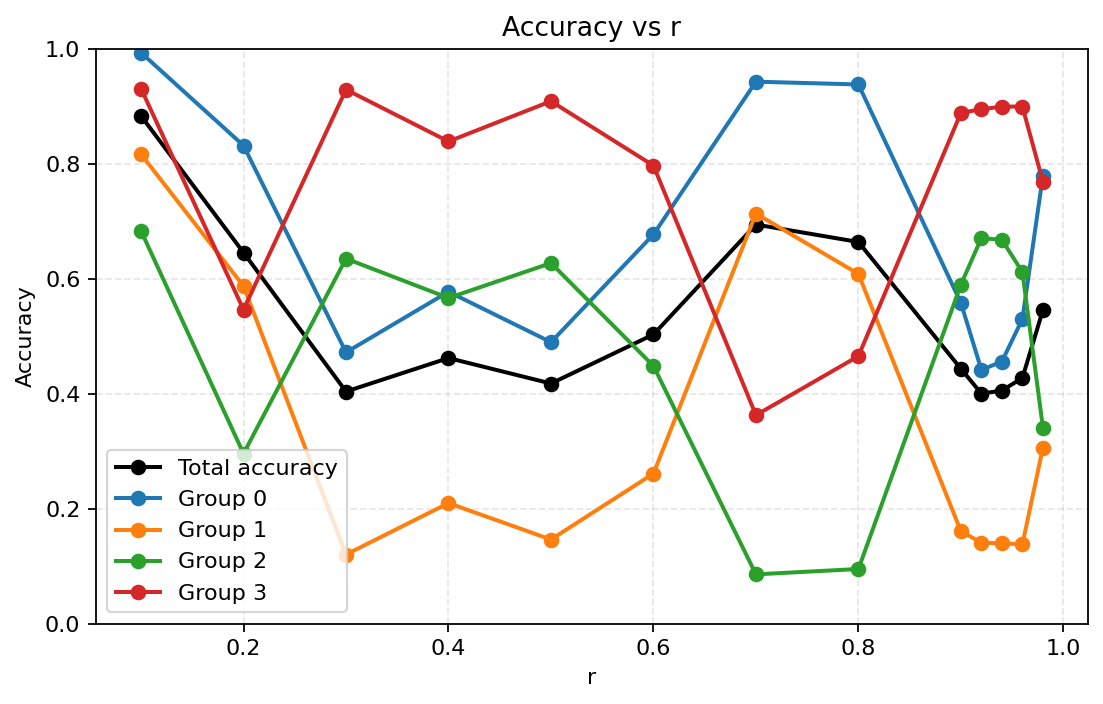

(<Figure size 1120x720 with 1 Axes>,
 <Axes: title={'center': 'Accuracy vs r'}, xlabel='r', ylabel='Accuracy'>)

In [10]:
plot_r_accuracy_lines(array, save_path = f'l2 viz/{dataset}_{layer_type}/acc_plot.png')

In [11]:
d = OrderedDict()
for i in range(len(rates)):
    d[i] = pruned['scores'][i].detach().cpu().numpy()
plot_layer_head_heatmap(d)

IndexError: list index out of range

In [ ]:
pruned = pruner.prune(model, r)

In [ ]:
pruned